# Plots (EDA)

In [1]:
import sys
import os

# Get the parent directory of the current directory (subdir2)
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir, os.pardir))
sys.path.append(parent_dir)

In [2]:
import pickle 
import numpy as np
from scipy.sparse.linalg import svds

import matplotlib.pyplot as plt
import seaborn as sns

from utils.data import convert_data

In [3]:
pictures_folder_path = "pictures_eda"

# Set the Computer Modern font
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "Computer Modern"
plt.rcParams["text.usetex"] = True

In [4]:
# Load the data from the pickle file
with open("huxley_2020.pkl", "rb") as stream:
    data = pickle.load(stream)

# Sort the data keys
data_keys = sorted(data.keys())

print(data)
print(data_keys)

{'0125': <164x250 sparse matrix of type '<class 'numpy.float64'>'
	with 1585 stored elements in Compressed Sparse Row format>, '0124': <164x250 sparse matrix of type '<class 'numpy.float64'>'
	with 2825 stored elements in Compressed Sparse Row format>, '0126': <164x250 sparse matrix of type '<class 'numpy.float64'>'
	with 1509 stored elements in Compressed Sparse Row format>, '0127': <164x250 sparse matrix of type '<class 'numpy.float64'>'
	with 2914 stored elements in Compressed Sparse Row format>, '0122': <164x250 sparse matrix of type '<class 'numpy.float64'>'
	with 2335 stored elements in Compressed Sparse Row format>, '0201': <164x250 sparse matrix of type '<class 'numpy.float64'>'
	with 1370 stored elements in Compressed Sparse Row format>, '0123': <164x250 sparse matrix of type '<class 'numpy.float64'>'
	with 2623 stored elements in Compressed Sparse Row format>, '0128': <164x250 sparse matrix of type '<class 'numpy.float64'>'
	with 2734 stored elements in Compressed Sparse Row 

In [5]:
# Convert the data to the format expected by the model
data = convert_data(data)

print(data)

<COO: shape=(14, 164, 250), dtype=int32, nnz=32641, fill_value=0>


In [6]:
# Store a list with the days of the data
days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"] * 2
days

['Monday',
 'Tuesday',
 'Wednesday',
 'Thursday',
 'Friday',
 'Saturday',
 'Sunday',
 'Monday',
 'Tuesday',
 'Wednesday',
 'Thursday',
 'Friday',
 'Saturday',
 'Sunday']

In [7]:
# Extract the data dimensions
T, N1, N2 = data.shape

# Set the number of training time steps
T_train = 10

## Number of links and new links

In [8]:
def plot_active(num_active, ratio_newly_active, ylabel_ax1, ylabel_ax2, filename: str):
    # Use a color-blind friendly palette
    colors = colors = plt.get_cmap("tab10").colors

    _, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 5), dpi=300)

    ax1.plot(
        range(1, T_train + 2),
        num_active[: T_train + 1],
        linestyle=":",
        marker="o",
        markersize=5,
        color=colors[0],
        label="Training",
    )
    ax1.plot(
        range(T_train + 1, T + 1),
        num_active[T_train:],
        linestyle=":",
        marker="o",
        markersize=5,
        color=colors[1],
        label="Validation",
    )
    ax1.set_ylabel(ylabel_ax1)
    ax1.legend()

    ax2.plot(
        range(1, T_train + 2),
        ratio_newly_active[: T_train + 1],
        linestyle=":",
        linewidth=2,
        marker="o",
        markersize=5,
        color=colors[0],
        label="Training",
    )
    ax2.plot(
        range(T_train + 1, T + 1),
        ratio_newly_active[T_train:],
        linestyle=":",
        linewidth=2,
        marker="o",
        markersize=5,
        color=colors[1],
        label="Validation",
    )
    ax2.set_ylabel(ylabel_ax2)
    ax2.legend()

    plt.xlabel("Time")

    plt.savefig(
        os.path.join(pictures_folder_path, filename),
        format="pdf",
        bbox_inches="tight",
    )

    plt.show()

In [9]:
# Compute the number of links at each time step
num_active = np.sum(data, axis=(1, 2)).todense()

In [10]:
# Compute the percentage of links at each time step
percentage_links = num_active / (N1 * N2)

# Print the percentage of links at each time step
for i, key in enumerate(data_keys):
    print(f"Day {key} - {days[i]}: {percentage_links[i]:.4f}")

Day 0120 - Monday: 0.0628
Day 0121 - Tuesday: 0.0665
Day 0122 - Wednesday: 0.0570
Day 0123 - Thursday: 0.0640
Day 0124 - Friday: 0.0689
Day 0125 - Saturday: 0.0387
Day 0126 - Sunday: 0.0368
Day 0127 - Monday: 0.0711
Day 0128 - Tuesday: 0.0667
Day 0129 - Wednesday: 0.0598
Day 0130 - Thursday: 0.0671
Day 0131 - Friday: 0.0677
Day 0201 - Saturday: 0.0334
Day 0202 - Sunday: 0.0357


In [11]:
# Initialize an array to accumulate the sum of links
activation_history = np.zeros((N1, N2))

# Compute the number of links at each time step
# that were never active before
new_link_list = np.zeros(T)
for t in range(T):
    # Calculate the number of new links added at this time step using logical operations
    new_links = (activation_history == 0) & (data[t] > 0)
    activation_history += data[t].todense()
    new_link_list[t] = np.sum(new_links)

# Calculate the ratio of new links to the total number of links at each time step
ratio_newly_active = new_link_list / num_active

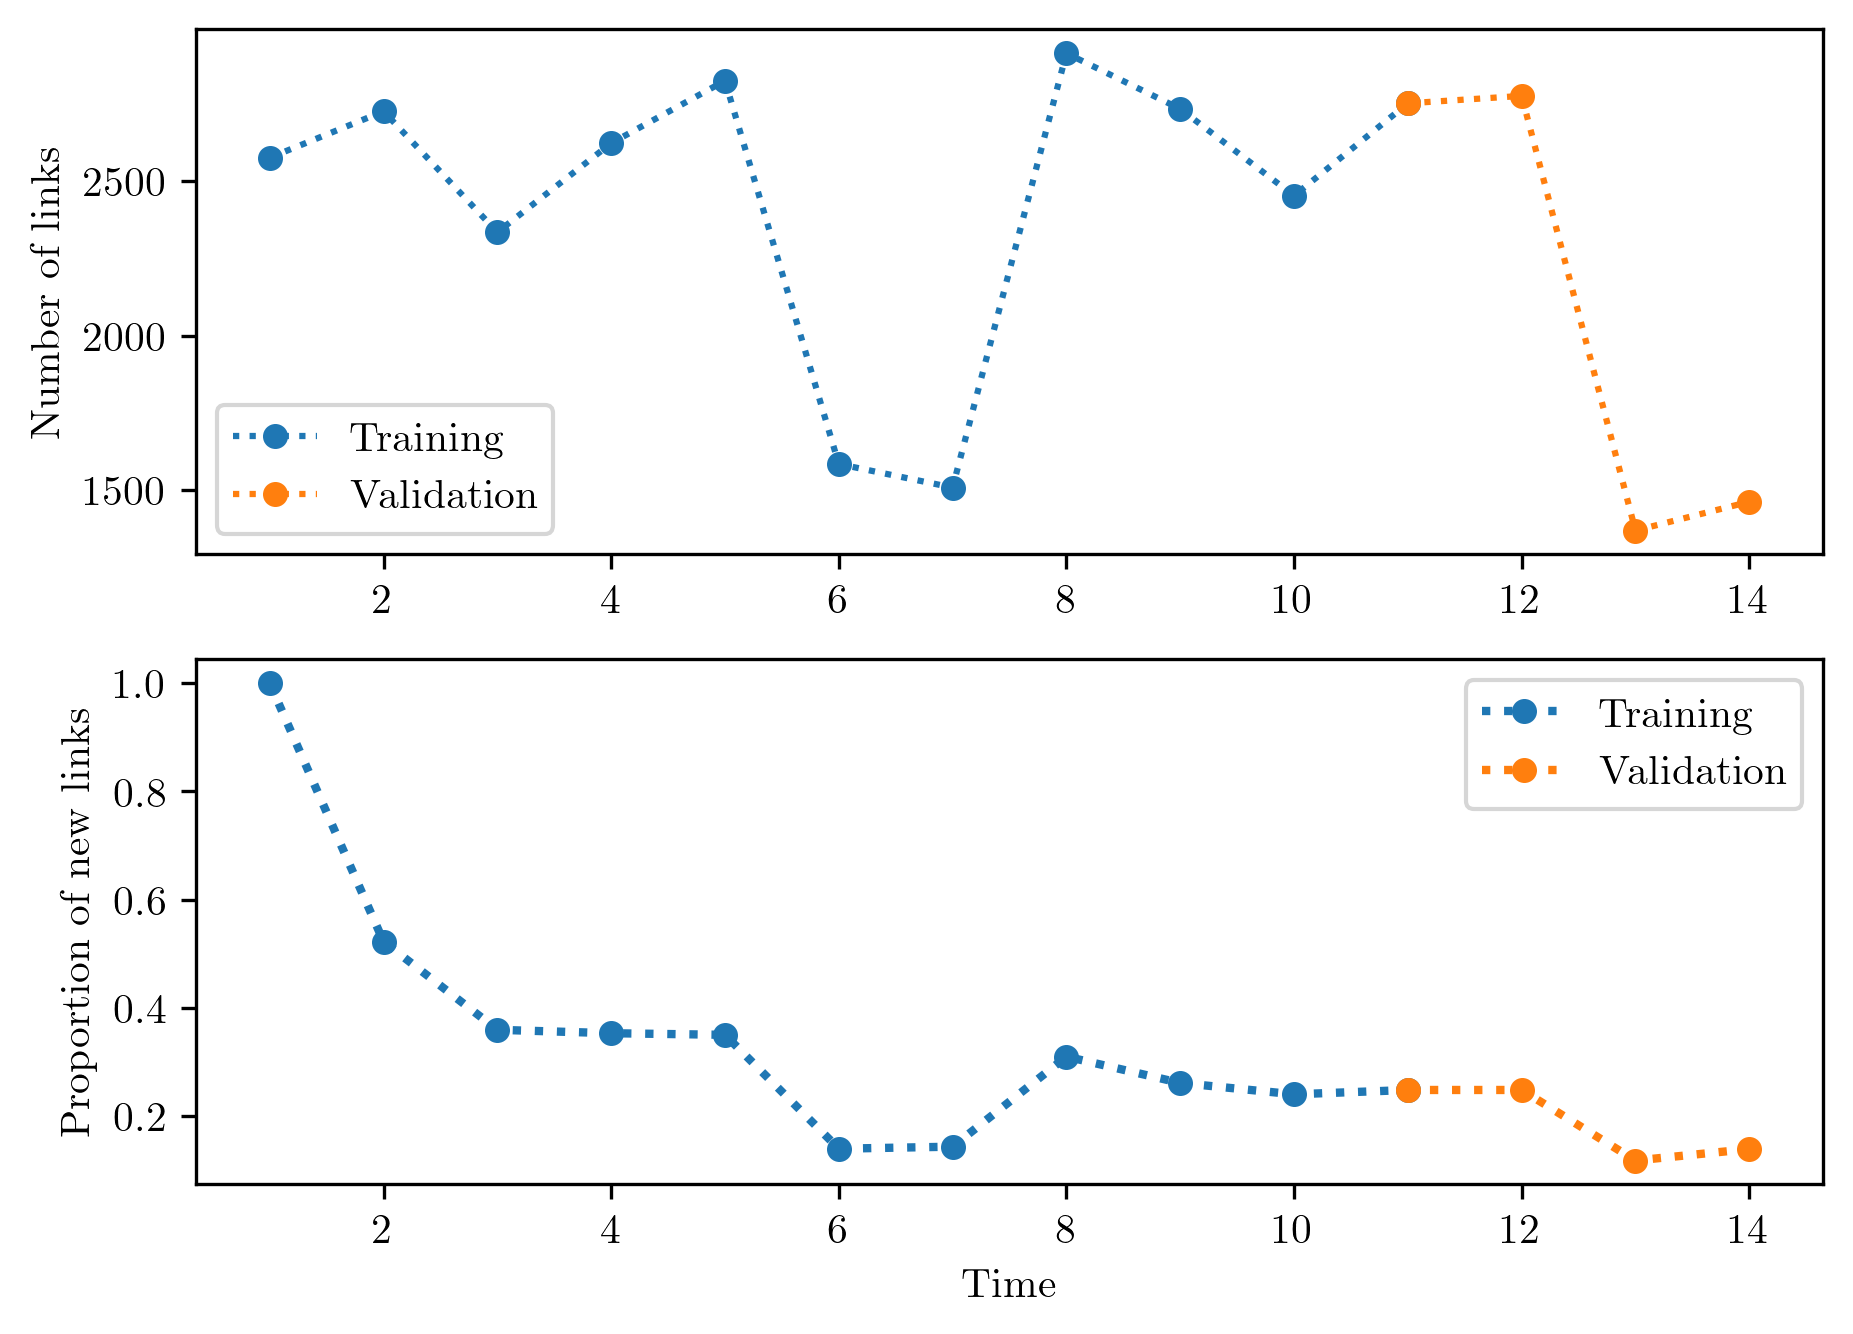

In [12]:
plot_active(
    num_active,
    ratio_newly_active,
    "Number of links",
    "Proportion of new links",
    "links.pdf",
)

In [13]:
# Compute the number of activate source nodes at each time step
num_active_source_nodes = np.sum(data.sum(axis=2) > 0, axis=1).todense()

# Initialize an array to store the activation history of each node
activation_history = np.zeros((data.shape[1],), dtype=bool)

# Initialize an array to store the newly activated nodes at each time step
newly_activated_nodes = np.zeros_like(num_active_source_nodes)

for t in range(data.shape[0]):
    # Find the nodes that are active at the current time step
    current_active_nodes = data[t].todense().sum(axis=1) > 0

    # Find the newly activated nodes (those that were not active before)
    new_activations = current_active_nodes & ~activation_history

    # Update the activation history
    activation_history |= current_active_nodes

    # Count the number of newly activated nodes
    newly_activated_nodes[t] = np.sum(new_activations)

# Calculate the ratio of newly activated source nodes to the number of activated source nodes
ratio_newly_activated_source_nodes = np.where(
    num_active_source_nodes > 0, newly_activated_nodes / num_active_source_nodes, 0
)

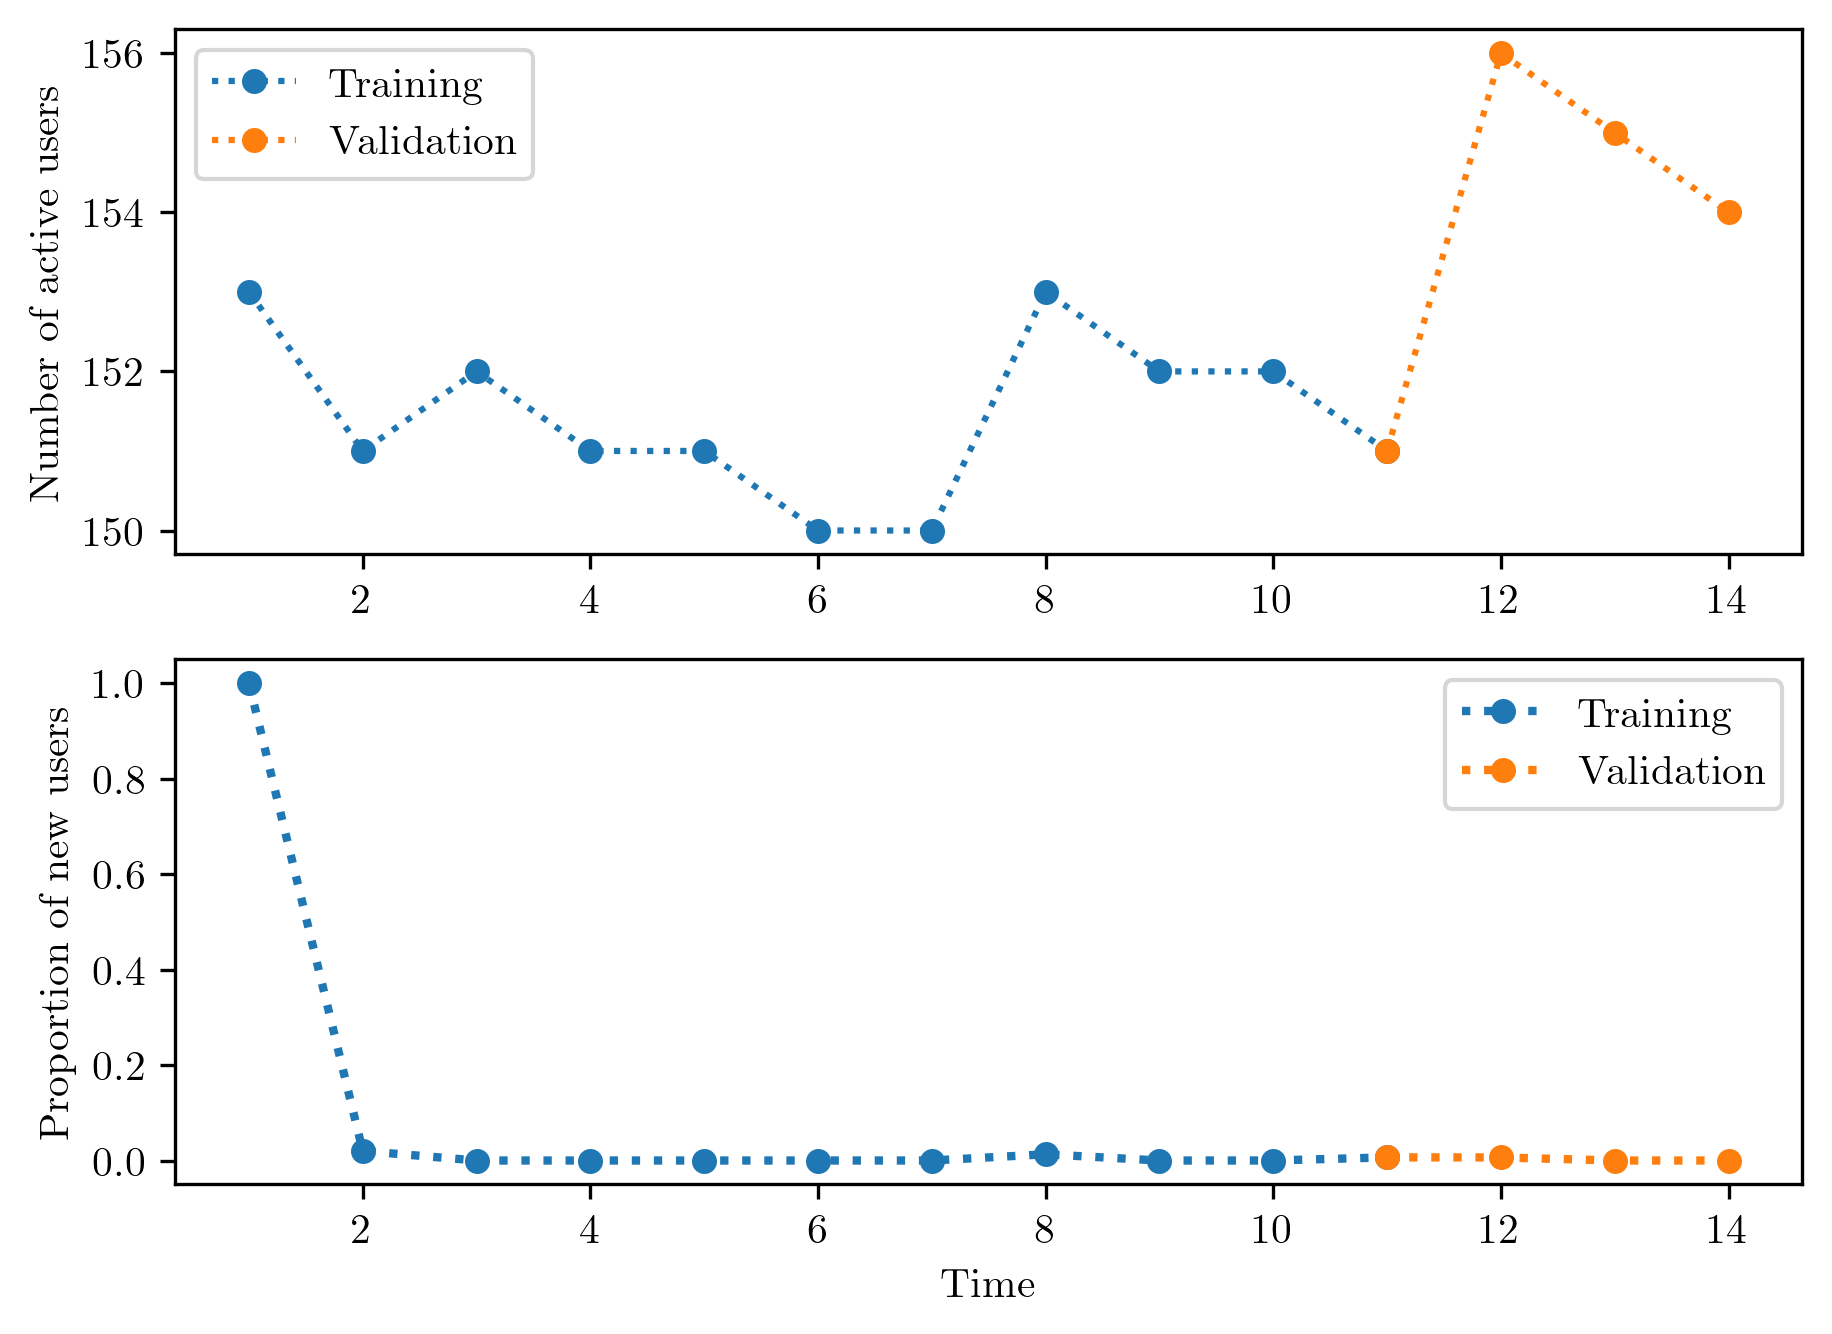

In [14]:
plot_active(
    num_active_source_nodes, 
    ratio_newly_activated_source_nodes,
    "Number of active users",
    "Proportion of new users",
    "users.pdf",
)   

In [15]:
# Compute the number of activated destination nodes at each time step
num_active_destination_nodes = np.sum(data.sum(axis=1) > 0, axis=1).todense()

# Initialize an array to store the activation history of each destination node
destination_activation_history = np.zeros((data.shape[2],), dtype=bool)

# Initialize an array to store the newly activated destination nodes at each time step
newly_activated_destination_nodes = np.zeros_like(num_active_destination_nodes)

for t in range(data.shape[0]):
    # Find the destination nodes that are active at the current time step
    current_active_destination_nodes = data[t].todense().sum(axis=0) > 0

    # Find the newly activated destination nodes (those that were not active before)
    new_destination_activations = current_active_destination_nodes & ~destination_activation_history

    # Update the activation history for destination nodes
    destination_activation_history |= current_active_destination_nodes

    # Count the number of newly activated destination nodes
    newly_activated_destination_nodes[t] = np.sum(new_destination_activations)

# Calculate the ratio of newly activated destination nodes to the number of activated destination nodes
ratio_newly_activated_destination_nodes = np.where(
    num_active_destination_nodes > 0, 
    newly_activated_destination_nodes / num_active_destination_nodes, 
    0
)

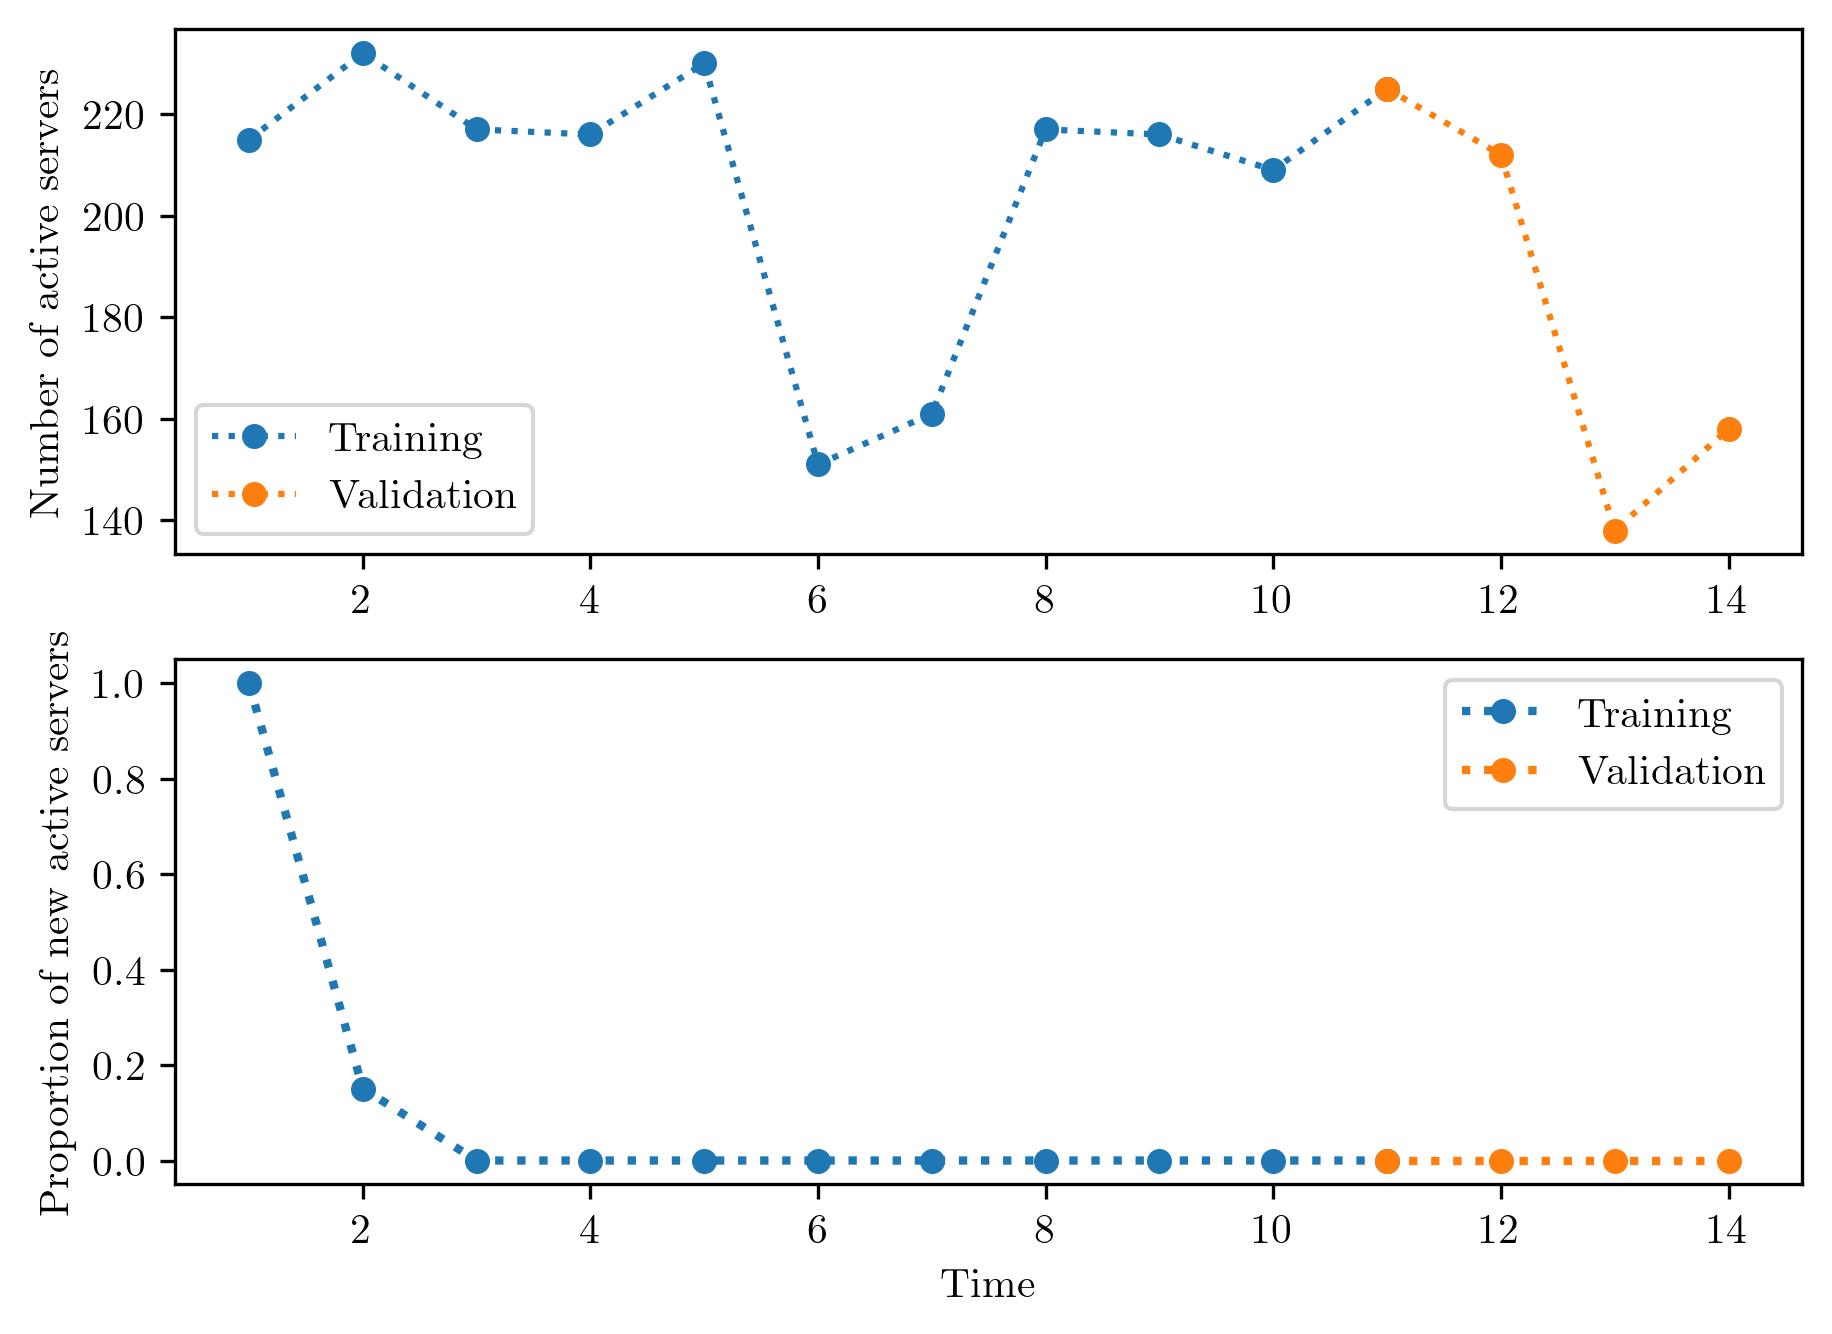

In [16]:
plot_active(
    num_active_destination_nodes,
    ratio_newly_activated_destination_nodes,
    "Number of active servers",
    "Proportion of new active servers",
    "servers.pdf",
)

## Visualisation of network

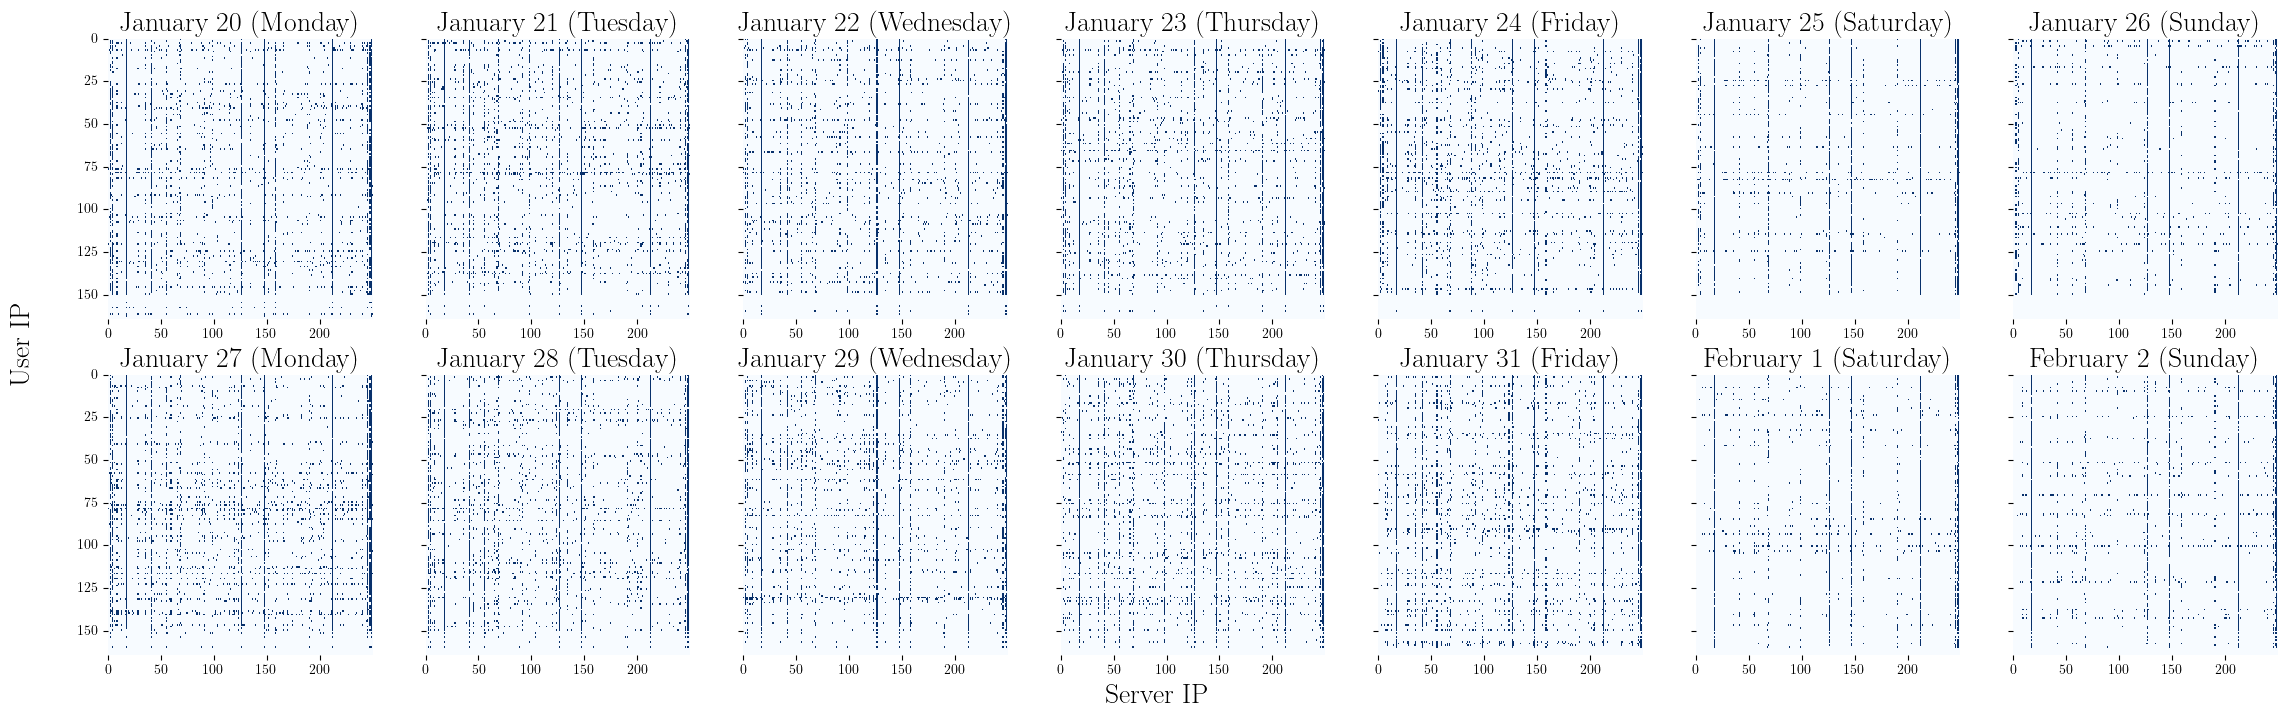

In [17]:
num_rows = 2
num_columns = 7

fig, ax = plt.subplots(
    num_rows,
    num_columns,
    sharey=True,
    figsize=(num_columns * 4, num_rows * 4),
)

# Flatten the axes array for easier indexing
ax = ax.flatten()

x_label_list = [i for i in range(0, N2, 50)]
y_label_list = [i for i in range(0, N1, 25)]

month = ["January", "February"]
for t in range(T):
    month_idx = int(data_keys[t]) // 100
    date_idx = int(data_keys[t]) % 100

    row_idx = t // num_columns
    col_idx = t % num_columns

    sns.heatmap(
        data[t].todense(),
        cbar=False,
        ax=ax[t],
        cmap="Blues",
    )

    ax[t].set_xticks(x_label_list)
    ax[t].set_yticks(y_label_list)
    ax[t].set_xticklabels(x_label_list, rotation=0)
    ax[t].set_yticklabels(y_label_list)

    ax[t].set_title(f"{month[month_idx - 1]} {date_idx} ({days[t]})", fontsize=20)

# Hide any remaining empty subplots
for t in range(T, len(ax)):
    ax[t].axis("off")

fig.text(0.5, 0.05, "Server IP", ha="center", fontsize=20)
fig.text(0.09, 0.5, "User IP", va="center", rotation="vertical", fontsize=20)

plt.savefig(
    os.path.join(pictures_folder_path, "heatmap.png"),
    format="png",
    bbox_inches="tight",
    dpi=300,
)

plt.show()

## Latent Dimension

In [18]:
# Perform SVD on the average data
average_data = np.mean(data, axis=0).todense()
_, D, _ = svds(average_data, k=50)

# Order the singular values in descending order
D = np.sort(D)[::-1]

# Set the number of latent dimensions
d = 7

# Print the first d singular values
print(D[:d])

[32.03314656  5.44528856  4.21729183  3.24476352  2.96195962  2.75894035
  2.39072312]


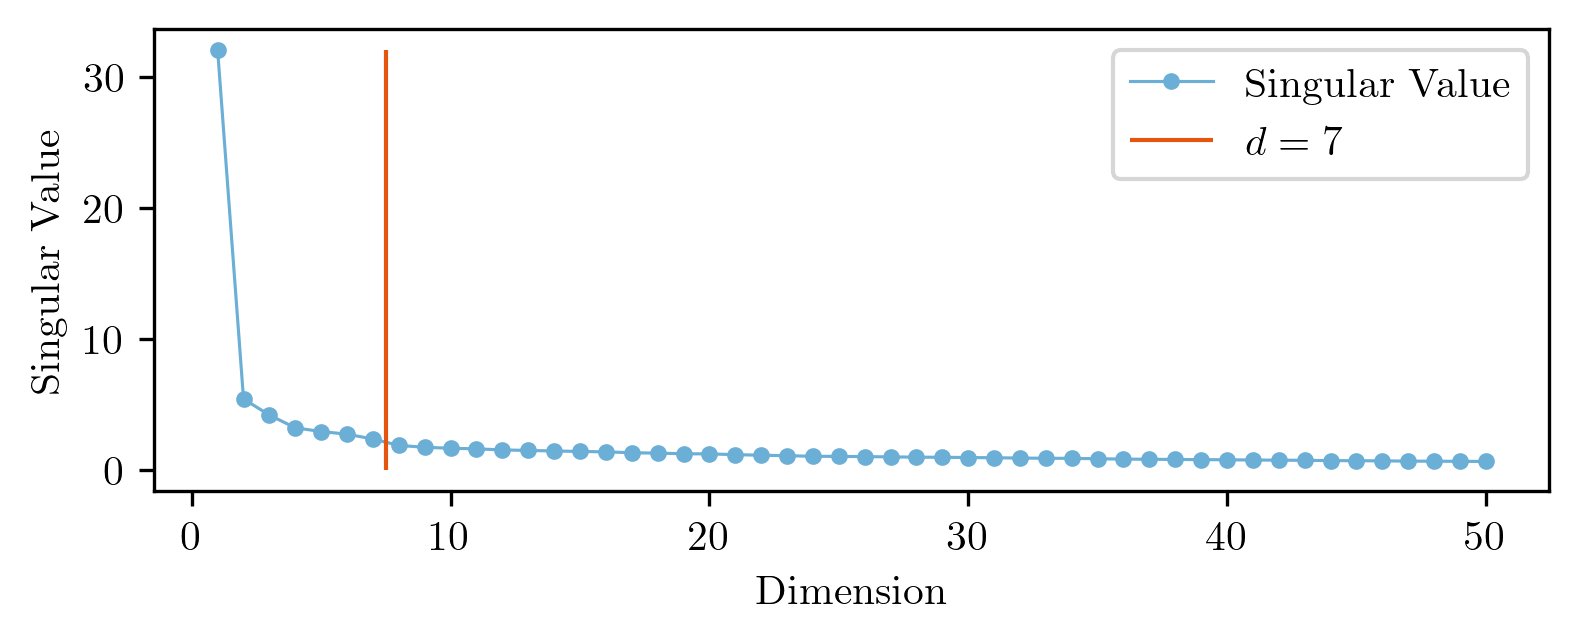

In [19]:
# Use a color-blind friendly palette
colors = colors = plt.get_cmap("tab20c").colors

# Plot the singular values
plt.figure(figsize=(6, 2), dpi=300)

plt.plot(
    range(1, len(D) + 1),
    D,
    linestyle="-",
    linewidth=0.75,
    marker="o",
    markersize=3,
    color=colors[1],
    label="Singular Value",
)
plt.vlines(
    x=d + 0.5,
    ymin=0,
    ymax=D[0],
    linestyle="-",
    linewidth=1,
    color=colors[4],
    label=fr"$d = {d}$",
)

plt.xlabel("Dimension")
plt.ylabel("Singular Value")
plt.legend()

plt.savefig(
    os.path.join(pictures_folder_path, "latent-dimension.pdf"),
    format="pdf",
    bbox_inches="tight",
)

plt.show()